In [1]:
from pyomo.environ import *
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pyomo.opt import SolverFactory
# import warnings
# warnings.filterwarnings('ignore')

We look at the impact of ESS in the utilization of wind energy.

## constants

In [2]:
SOC0 = 100   # MW

SOCmax = 300 # MW

etac = 0.95  #efficiency of charging

etad = 0.9   #efficiency of discharging

VWC = 50    #Value of wind curtailment

## sets

In [3]:
t_hours = ['t1', 't2', 't3', 't4', 't5', 't6', 't7', 't8', 't9', 't10', 't11', 't12', 't13', 't14', 't15', 't16', 't17', 't18', 't19', 't20', 't21', 't22', 't23', 't24']
g_units = ['p1', 'p2', 'p3', 'p4']

## input data

In [4]:
# a is in $ / MW^2   . cost coefficient for a thermal unit
# b is in $ / MW       cost coefficient for a thermal unit
# c is in $            cost coefficient for a thermal unit
# d is in kg/MW^2      emissions coefficient for a thermal unit
# e is in kW/MW        emissions coefficient for a thermal unit
# f is in kg           emissions coefficient for a thermal unit
# Pmin, Pmax are in MW.  Min and Max output limits for a thermal unit
# RU, RD are in MW       Ramp up / down rates for a thermal unit

#this is a dictionary . The key is a tuple.

# Data tables
gendata = {
    ('p1', 'a'): 0.12, 
    ('p1', 'b'): 14.80, 
    ('p1', 'c'):  89, 
    ('p1', 'd'): 1.2, 
    ('p1', 'e'): -5.00, 
    ('p1', 'f'): 3.00, 
    ('p1', 'Pmin'): 28, 
    ('p1', 'Pmax'): 200, 
    ('p1', 'RU0'): 40, 
    ('p1', 'RD0'): 40,
    
    ('p2', 'a'): 0.17, 
    ('p2', 'b'): 16.57, 
    ('p2', 'c'):  83, 
    ('p2', 'd'): 2.3, 
    ('p2', 'e'): -4.24, 
    ('p2', 'f'): 6.09, 
    ('p2', 'Pmin'): 20, 
    ('p2', 'Pmax'): 290, 
    ('p2', 'RU0'): 30, 
    ('p2', 'RD0'): 30,
    
    ('p3', 'a'): 0.15, 
    ('p3', 'b'): 15.55, 
    ('p3', 'c'): 100, 
    ('p3', 'd'): 1.1, 
    ('p3', 'e'): -2.15, 
    ('p3', 'f'): 5.69, 
    ('p3', 'Pmin'): 30, 
    ('p3', 'Pmax'): 190, 
    ('p3', 'RU0'): 30, 
    ('p3', 'RD0'): 30,
    
    ('p4', 'a'): 0.19, 
    ('p4', 'b'): 16.21, 
    ('p4', 'c'):  70, 
    ('p4', 'd'): 1.1, 
    ('p4', 'e'): -3.99, 
    ('p4', 'f'): 6.20, 
    ('p4', 'Pmin'): 20, 
    ('p4', 'Pmax'): 260, 
    ('p4', 'RU0'): 50, 
    ('p4', 'RD0'): 50
}

gendata



{('p1', 'a'): 0.12,
 ('p1', 'b'): 14.8,
 ('p1', 'c'): 89,
 ('p1', 'd'): 1.2,
 ('p1', 'e'): -5.0,
 ('p1', 'f'): 3.0,
 ('p1', 'Pmin'): 28,
 ('p1', 'Pmax'): 200,
 ('p1', 'RU0'): 40,
 ('p1', 'RD0'): 40,
 ('p2', 'a'): 0.17,
 ('p2', 'b'): 16.57,
 ('p2', 'c'): 83,
 ('p2', 'd'): 2.3,
 ('p2', 'e'): -4.24,
 ('p2', 'f'): 6.09,
 ('p2', 'Pmin'): 20,
 ('p2', 'Pmax'): 290,
 ('p2', 'RU0'): 30,
 ('p2', 'RD0'): 30,
 ('p3', 'a'): 0.15,
 ('p3', 'b'): 15.55,
 ('p3', 'c'): 100,
 ('p3', 'd'): 1.1,
 ('p3', 'e'): -2.15,
 ('p3', 'f'): 5.69,
 ('p3', 'Pmin'): 30,
 ('p3', 'Pmax'): 190,
 ('p3', 'RU0'): 30,
 ('p3', 'RD0'): 30,
 ('p4', 'a'): 0.19,
 ('p4', 'b'): 16.21,
 ('p4', 'c'): 70,
 ('p4', 'd'): 1.1,
 ('p4', 'e'): -3.99,
 ('p4', 'f'): 6.2,
 ('p4', 'Pmin'): 20,
 ('p4', 'Pmax'): 260,
 ('p4', 'RU0'): 50,
 ('p4', 'RD0'): 50}

In [5]:
#both in MW. The "wind" is thew maximum possible output from wind units (wind availability).

data = {
    ('t1', 'load'): 510, ('t1', 'wind'): 44.1,
    ('t2', 'load'): 530, ('t2', 'wind'): 48.5,
    ('t3', 'load'): 516, ('t3', 'wind'): 65.7,
    ('t4', 'load'): 510, ('t4', 'wind'): 144.9,
    ('t5', 'load'): 515, ('t5', 'wind'): 202.3,
    ('t6', 'load'): 544, ('t6', 'wind'): 317.3,
    ('t7', 'load'): 646, ('t7', 'wind'): 364.4,
    ('t8', 'load'): 686, ('t8', 'wind'): 317.3,
    ('t9', 'load'): 741, ('t9', 'wind'): 271,
    ('t10', 'load'): 734, ('t10', 'wind'): 306.9,
    ('t11', 'load'): 748, ('t11', 'wind'): 424.1,
    ('t12', 'load'): 760, ('t12', 'wind'): 398,
    ('t13', 'load'): 754, ('t13', 'wind'): 487.6,
    ('t14', 'load'): 700, ('t14', 'wind'): 521.9,
    ('t15', 'load'): 686, ('t15', 'wind'): 541.3,
    ('t16', 'load'): 720, ('t16', 'wind'): 560,
    ('t17', 'load'): 714, ('t17', 'wind'): 486.8,
    ('t18', 'load'): 761, ('t18', 'wind'): 372.6,
    ('t19', 'load'): 727, ('t19', 'wind'): 367.4,
    ('t20', 'load'): 714, ('t20', 'wind'): 314.3,
    ('t21', 'load'): 618, ('t21', 'wind'): 316.6,
    ('t22', 'load'): 584, ('t22', 'wind'): 311.4,
    ('t23', 'load'): 578, ('t23', 'wind'): 405.4,
    ('t24', 'load'): 544, ('t24', 'wind'): 470.4
}

## defining the optimization model

In [6]:
model = ConcreteModel()
model.name= "Wind Integrated DED"

##### adding the sets to the model 

In [7]:
model.t_hours = Set(initialize=t_hours)

In [8]:
model.g_units = Set(initialize=g_units)

#####  Decision Variables 

In [9]:
model.p = Var(model.g_units, model.t_hours, bounds=lambda model, g, t: (gendata[g, 'Pmin'], gendata[g, 'Pmax']))

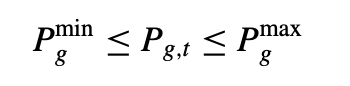

In [10]:
model.SOC = Var(model.t_hours, bounds=lambda model, t: (0.2 * SOCmax, SOCmax))

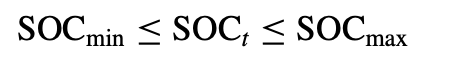

In [11]:
model.Pd = Var(model.t_hours, bounds=(0, 0.2 * SOCmax))

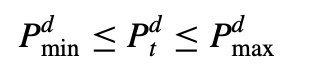

In [12]:
model.Pc = Var(model.t_hours, bounds=(0, 0.2 * SOCmax))

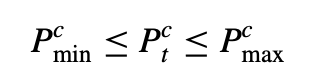

###### We fix the very last SOC (which is a decision variable) with the SOC at the very beginning. This is a very common assumption.

In [13]:
model.SOC['t24'].fix(SOC0)

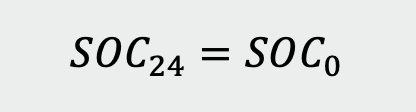

output (MW) from wind units at time t:

In [14]:
model.Pw = Var(model.t_hours, bounds=lambda model, t: (0, data[t, 'wind']))

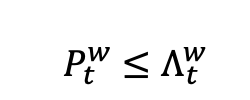

curtailed wind output (MW) at time t:

In [15]:
model.PWC = Var(model.t_hours,bounds=lambda model, t: (0,data[t, 'wind']))

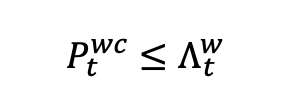

##### objective function. We minimize the Total electricity generation Cost (TC). This is a quadratic objective function ie nonlinear problem

In [16]:
model.costThermal = Objective(
    expr=
    sum(VWC * model.PWC[t] for t in model.t_hours) + 
    sum(gendata[g, 'a'] * model.p[g, t]**2 + gendata[g, 'b'] * model.p[g, t] + gendata[g, 'c']
             for t in model.t_hours for g in model.g_units),
    sense=minimize
)

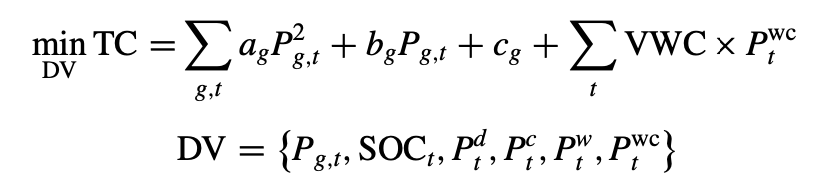

DV is the set of Decision Variables in the problem

#####  constraints

In [17]:
def Genconst_rule(model, g, t):
    if t == 't24':
        return Constraint.Skip
    else:
        return model.p[g, t_hours[t_hours.index(t) + 1]]  - model.p[g, t] <= gendata[g, 'RU0']

In [18]:
model.Genconst3 = Constraint(
    model.g_units, 
    model.t_hours, 
    rule=Genconst_rule)

In [19]:
# model.Genconst3 = Constraint(
#     model.g_units, 
#     model.t_hours, 
#     rule=lambda model, g, t: 
#     model.p[g, t] - model.p[g, t_hours[t_hours.index(t) - 1]] <= gendata[g, 'RU0'])

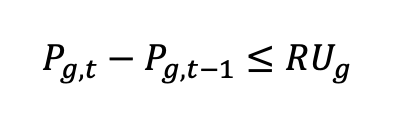

there is some difference in the above. The first:

    p(g,t2) - p(g,t1) <= RU0
    p(g,t3) - p(g,t2) <= RU0
    ...
    p(g,t24) -p(g,t23)<= RU0
    
    
    
    
    The second:
    p(g,t1) - p(g,t24) <= RU0
    p(g,t2) - p(g,t1)  <= RU0
    p(g,t3) - p(g,t2)  <= RU0
    ...
    p(g,t24) -p(g,t23) <= RU0

In [20]:
t_hours

['t1',
 't2',
 't3',
 't4',
 't5',
 't6',
 't7',
 't8',
 't9',
 't10',
 't11',
 't12',
 't13',
 't14',
 't15',
 't16',
 't17',
 't18',
 't19',
 't20',
 't21',
 't22',
 't23',
 't24']

In [21]:
t_hours.index('t24')

23

In [22]:
t_hours.index('t24') + 1

24

In [23]:
# above, we have constraint.skip because of this: t_hours[24] gives "list index out of range"



In [24]:
model.Genconst4 = Constraint(
    model.g_units, 
    model.t_hours, 
    rule=lambda model, g, t: 
    model.p[g, t_hours[t_hours.index(t) - 1]] - model.p[g, t] <= gendata[g, 'RD0'])

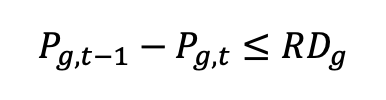

The State of Charge (SOC) for the Energy Storage:

In [25]:
def constESS1_rule(model, t):
    if t == 't1':
        return model.SOC[t] == SOC0 + model.Pc[t] * etac - model.Pd[t] / etad
    else:
        return model.SOC[t] == model.SOC[t_hours[t_hours.index(t) - 1]] + model.Pc[t] * etac - model.Pd[t] / etad

In [26]:
model.constESS1 = Constraint(model.t_hours, rule=constESS1_rule)

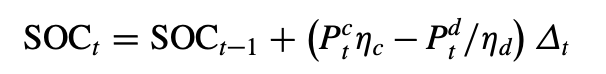

In [27]:
model.balance = Constraint(
    model.t_hours, 
    rule=lambda model, t: 
    model.Pw[t] + sum(model.p[g, t] for g in model.g_units) + model.Pd[t] == data[t, 'load'] + model.Pc[t])

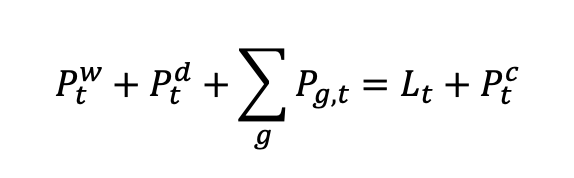

In [28]:
model.wind = Constraint(
    model.t_hours, 
    rule=lambda model, t: model.Pw[t] + model.PWC[t] == data[t, 'wind'])

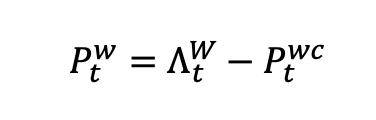

In [29]:
model.EM = Var(bounds=(0, None))

In [30]:


model.EMcalc = Constraint(
    rule=lambda model: 
    model.EM == sum(gendata[g, 'd'] * model.p[g, t]**2 + gendata[g, 'e'] * model.p[g, t] + gendata[g, 'f'] 
                          for t in model.t_hours for g in model.g_units))


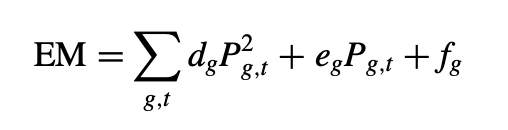

## Solution

In [31]:
solver = SolverFactory('gurobi')  

In [32]:
solver.options['NonConvex'] = 2

In [33]:
result_wind = solver.solve(model)

In [34]:
result_wind['Problem'][0]['Number of objectives']  

1

In [35]:
model.display() 

Model Wind Integrated DED

  Variables:
    p : Size=96, Index=p_index
        Key           : Lower : Value              : Upper : Fixed : Stale : Domain
         ('p1', 't1') :    28 : 148.88356029324214 :   200 : False : False :  Reals
        ('p1', 't10') :    28 : 132.41323954578695 :   200 : False : False :  Reals
        ('p1', 't11') :    28 : 106.87507400842512 :   200 : False : False :  Reals
        ('p1', 't12') :    28 : 119.01865008837967 :   200 : False : False :  Reals
        ('p1', 't13') :    28 :   88.5481547269621 :   200 : False : False :  Reals
        ('p1', 't14') :    28 :  79.52812314512191 :   200 : False : False :  Reals
        ('p1', 't15') :    28 :  68.88257351452506 :   200 : False : False :  Reals
        ('p1', 't16') :    28 :  73.75912768844823 :   200 : False : False :  Reals
        ('p1', 't17') :    28 :  80.02449642214654 :   200 : False : False :  Reals
        ('p1', 't18') :    28 : 108.30935464829568 :   200 : False : False :  Reals
     

Total emissions in this DED-ESS-Wind = 870,440 kg CO2  

Total emissions in the  DED-ESS      = 3,592,887 kg CO2  

Total emissions in the  DED          = 3,558,327  kg CO2   

Total Electricity Generation Cost in the DED - ESS - Wind = $223,360  
  
Total Electricity Generation Cost in the DED - ESS      = $645,525    

Total Electricity Generation Cost in the DED          = $647,964      



In [36]:
result_wind['Problem'][0]['Lower bound']  

223348.88328723985

In [37]:
result_wind['Problem'][0]['Upper bound'] #This is the TC

223360.06445447725

In [38]:
result_wind['Problem'][0]['Upper bound']  == result_wind['Problem'][0]['Lower bound']  #equal to each other. Convergence

False

In [39]:
result_wind['Problem'][0]['Number of constraints']  

261

In [40]:
result_wind['Problem'][0]['Number of variables']  

217

In [41]:
result_wind['Problem'][0]['Number of binary variables']  

0

In [42]:
result_wind['Problem'][0]['Number of binary variables']  

0

In [43]:
result_wind['Problem'][0]['Number of binary variables']  

0

In [44]:
result_wind['Problem'][0]['Number of continuous variables']  

217

In [45]:
result_wind['Problem'][0]['Sense']

<ProblemSense.minimize: 'minimize'>

In [46]:
result_wind['Solver'][0]['Message']

'Model was solved to optimality (subject to tolerances), and an optimal solution is available.'

In [47]:
result_wind['Solver'][0]['Termination condition']

<TerminationCondition.optimal: 'optimal'>

In [48]:
result_wind['Solver'][0]['Time'] #solution time ie how much time it took to solve

0.4783759117126465

In [49]:
model.p['p1','t1'].value  #shows the optimal value ie output of p1 at t1 in MW.

148.88356029324214

#### Plots

In [50]:
#same as the values of the input 'data' that we defined above. This is the load in MW
L_lst = [510.00,
         530.00,
         516.00,
         510.00,
         515.00,
         544.00,
         646.00,
         686.00,
         741.00,
         734.00,
         748.00,
         760.00,
         754.00,
         700.00,
         686.00,
         720.00,
         714.00,
         761.00,
         727.00,
         714.00,
         618.00,
         584.00,
         578.00,
         544.00]

In [51]:
pg_lst = []

for t in model.t_hours:  # ['t1', 't2', etc.... 't24'] . Eg 't1'
    val = 0
    for g in model.g_units:  # ['p1', 'p2', 'p3', 'p4']
        val +=model.p[g, t].value  # we sum the output of p1, p2, p3, p4, at periot t. Ie total output per period. 
    
    pg_lst.append(round(val, 2))

In [52]:
soc_lst = []

for t in model.t_hours:  # ['t1', 't2', etc.... 't24'] . Eg 't1'
    soc_lst.append(round(model.SOC[t].value, 2))

soc_lst  # State of charge (MWh) of the storage unit

[88.67,
 60.0,
 60.0,
 60.0,
 62.88,
 119.88,
 152.31,
 152.31,
 85.64,
 60.0,
 60.0,
 60.0,
 60.0,
 117.0,
 174.0,
 231.0,
 242.83,
 176.17,
 126.67,
 60.0,
 60.0,
 60.0,
 60.0,
 100]

In [53]:
pd_lst = []

for t in model.t_hours:  # ['t1', 't2', etc.... 't24'] . Eg 't1'
    pd_lst.append(round(model.Pd[t].value, 2))

pd_lst  # discharged power (MW) of the storage unit

[10.2,
 25.8,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 60.0,
 23.07,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 60.0,
 44.55,
 60.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [54]:
pc_lst = []

for t in model.t_hours:  # ['t1', 't2', etc.... 't24'] . Eg 't1'
    pc_lst.append(round(model.Pc[t].value, 2))
pc_lst  # charged power (MW) of the storage unit

[0.0,
 0.0,
 0.0,
 0.0,
 3.03,
 60.0,
 34.13,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 60.0,
 60.0,
 60.0,
 12.46,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 42.11]

In [55]:
pw_lst = []

for t in model.t_hours:  # ['t1', 't2', etc.... 't24'] . Eg 't1'
    pw_lst.append(round(model.Pw[t].value, 2))
pw_lst  # Wind generation at time t in MW

[44.1,
 48.5,
 65.7,
 144.9,
 202.3,
 317.3,
 364.4,
 317.3,
 271.0,
 306.9,
 424.1,
 398.0,
 487.6,
 521.9,
 541.3,
 560.0,
 486.8,
 372.6,
 367.4,
 314.3,
 316.6,
 311.4,
 405.4,
 470.4]

In [56]:
pwc_lst = []

for t in model.t_hours:  # ['t1', 't2', etc.... 't24'] . Eg 't1'
    pwc_lst.append(round(model.PWC[t].value, 2))
pwc_lst  # Wind curtailment at time t

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

placing all the above in one place

In [57]:
list1 = [ L_lst, pg_lst, soc_lst, pd_lst, pc_lst, pw_lst, pwc_lst] 

In [58]:
dataframe1 = pd.DataFrame(np.array(list1)) #the array is converted to a dataframe
dataframe1

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,510.00,530.0,516.0,510.0,515.00,544.00,646.00,686.00,741.00,734.00,...,686.0,720.0,714.00,761.00,727.00,714.0,618.0,584.0,578.0,544.00
1,455.70,455.7,450.3,365.1,315.73,286.70,315.73,368.70,410.00,404.03,...,204.7,220.0,239.66,328.40,315.05,339.7,301.4,272.6,172.6,115.71
2,88.67,60.0,60.0,60.0,62.88,119.88,152.31,152.31,85.64,60.00,...,174.0,231.0,242.83,176.17,126.67,60.0,60.0,60.0,60.0,100.00
3,10.20,25.8,0.0,0.0,0.00,0.00,0.00,0.00,60.00,23.07,...,0.0,0.0,0.00,60.00,44.55,60.0,0.0,0.0,0.0,0.00
4,0.00,0.0,0.0,0.0,3.03,60.00,34.13,0.00,0.00,0.00,...,60.0,60.0,12.46,0.00,0.00,0.0,0.0,0.0,0.0,42.11
5,44.10,48.5,65.7,144.9,202.30,317.30,364.40,317.30,271.00,306.90,...,541.3,560.0,486.80,372.60,367.40,314.3,316.6,311.4,405.4,470.40
6,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00


In [59]:
data_tables = dataframe1.T  #we transpose it ie its rows become columns, and its columns become rows.
data_tables

,0,1,2,3,4,5,6
0,510.0,455.70,88.67,10.20,0.00,44.1,0.0
1,530.0,455.70,60.00,25.80,0.00,48.5,0.0
2,516.0,450.30,60.00,0.00,0.00,65.7,0.0
3,510.0,365.10,60.00,0.00,0.00,144.9,0.0
4,515.0,315.73,62.88,0.00,3.03,202.3,0.0
5,544.0,286.70,119.88,0.00,60.00,317.3,0.0
6,646.0,315.73,152.31,0.00,34.13,364.4,0.0
7,686.0,368.70,152.31,0.00,0.00,317.3,0.0
8,741.0,410.00,85.64,60.00,0.00,271.0,0.0
9,734.0,404.03,60.00,23.07,0.00,306.9,0.0


In [60]:
data_tables.index = range(1,25) 
data_tables

,0,1,2,3,4,5,6
1,510.0,455.70,88.67,10.20,0.00,44.1,0.0
2,530.0,455.70,60.00,25.80,0.00,48.5,0.0
3,516.0,450.30,60.00,0.00,0.00,65.7,0.0
4,510.0,365.10,60.00,0.00,0.00,144.9,0.0
5,515.0,315.73,62.88,0.00,3.03,202.3,0.0
6,544.0,286.70,119.88,0.00,60.00,317.3,0.0
7,646.0,315.73,152.31,0.00,34.13,364.4,0.0
8,686.0,368.70,152.31,0.00,0.00,317.3,0.0
9,741.0,410.00,85.64,60.00,0.00,271.0,0.0
10,734.0,404.03,60.00,23.07,0.00,306.9,0.0


In [61]:
data_tables.columns = ["Lt","Pg",'SOC','PD','Pc', 'PW', 'PWC']
data_tables

,Lt,Pg,SOC,PD,Pc,PW,PWC
1,510.0,455.70,88.67,10.20,0.00,44.1,0.0
2,530.0,455.70,60.00,25.80,0.00,48.5,0.0
3,516.0,450.30,60.00,0.00,0.00,65.7,0.0
4,510.0,365.10,60.00,0.00,0.00,144.9,0.0
5,515.0,315.73,62.88,0.00,3.03,202.3,0.0
6,544.0,286.70,119.88,0.00,60.00,317.3,0.0
7,646.0,315.73,152.31,0.00,34.13,364.4,0.0
8,686.0,368.70,152.31,0.00,0.00,317.3,0.0
9,741.0,410.00,85.64,60.00,0.00,271.0,0.0
10,734.0,404.03,60.00,23.07,0.00,306.9,0.0


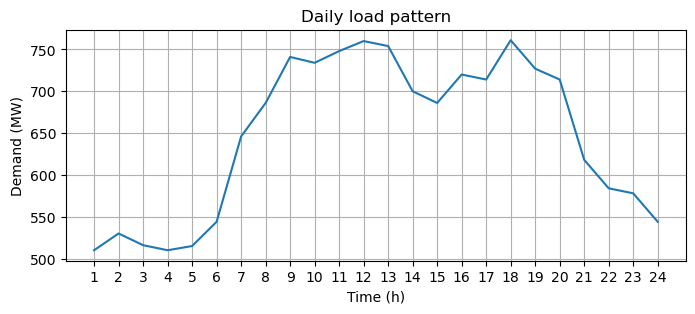

In [62]:
plt.figure(figsize=(8, 3))
plt.plot(t_hours, L_lst, '-')

plt.xlabel('Time (h)')
plt.ylabel('Demand (MW)')
plt.title('Daily load pattern')
xticks = range(1,25)
plt.xticks(t_hours, xticks)
plt.grid()
plt.show()

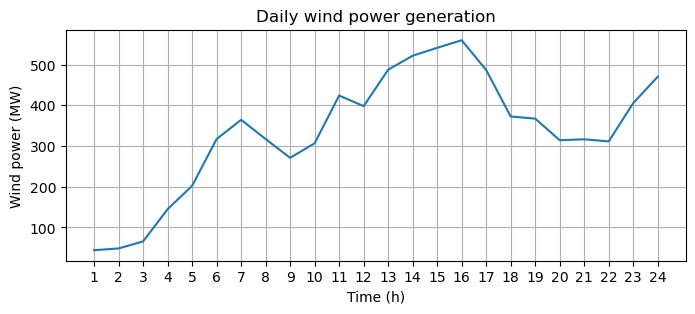

In [63]:
plt.figure(figsize=(8, 3))
plt.plot(t_hours, pw_lst, '-')

plt.xlabel('Time (h)')
plt.ylabel('Wind power (MW)')
plt.title('Daily wind power generation')
xticks = range(1,25)
plt.xticks(t_hours, xticks)
plt.grid()
plt.show()

/var/folders/d7/8ygtg6356sx5s_qd3z8tdx3h0000gn/T/ipykernel_53226/2478493426.py:3: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(t_hours, pg_lst, '-', label='Total Power by Thermal Units', linestyle='dashed')


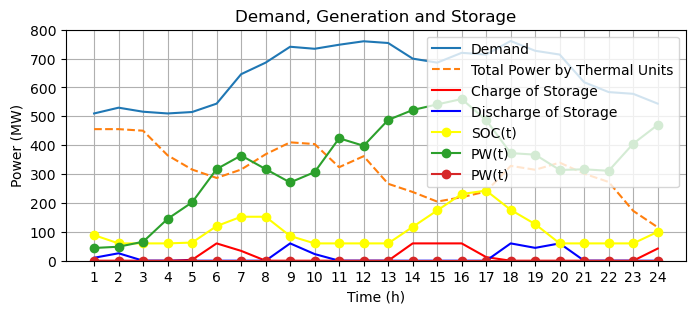

In [64]:
plt.figure(figsize=(8, 3))
plt.plot(t_hours, L_lst, '-', label='Demand')
plt.plot(t_hours, pg_lst, '-', label='Total Power by Thermal Units', linestyle='dashed')
plt.plot(t_hours, pc_lst,'-',color='red', label='Charge of Storage')
plt.plot(t_hours, pd_lst,color='blue', label='Discharge of Storage')
plt.plot(t_hours, soc_lst, 'o-', color='yellow', label='SOC(t)')
plt.plot(t_hours, pw_lst, 'o-', label='PW(t)')
plt.plot(t_hours, pwc_lst, 'o-', label='PWC(t)')

plt.ylim([0,800])
plt.xlabel('Time (h)')
plt.ylabel('Power (MW)')
plt.title('Demand, Generation and Storage')
xticks = range(1,25)
plt.xticks(t_hours, xticks)
plt.legend()
plt.grid()
plt.show()

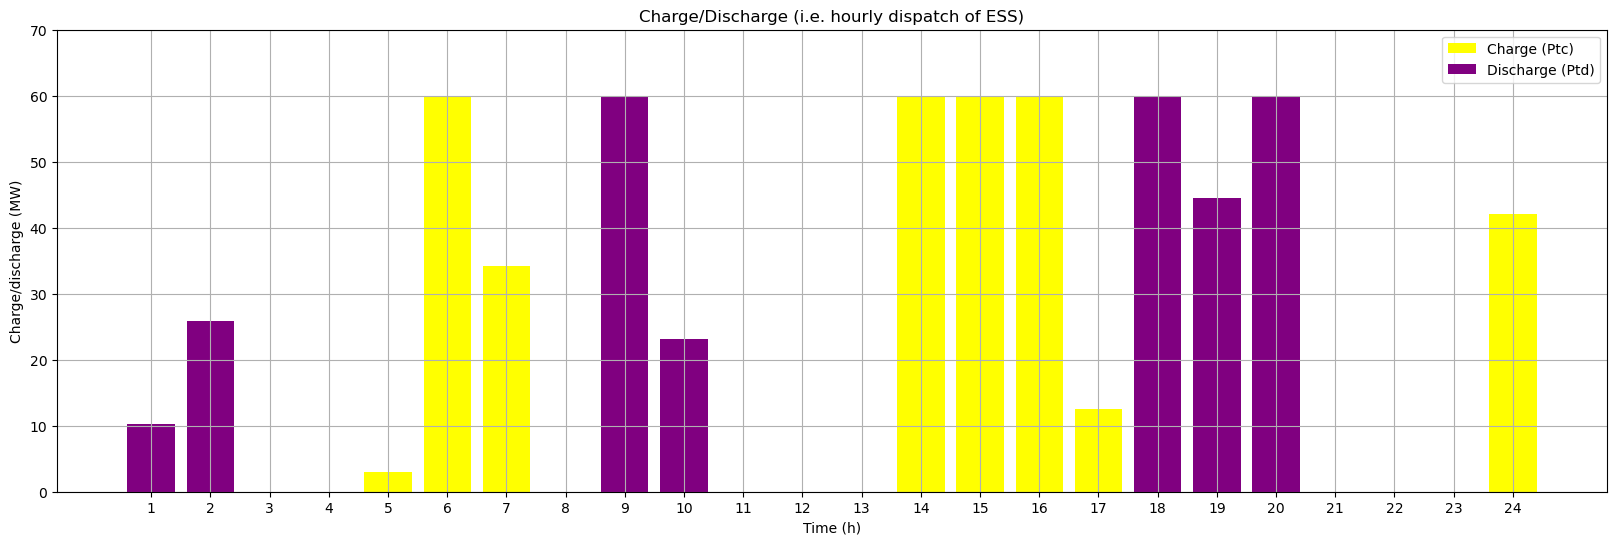

In [65]:
plt.figure(figsize=(20, 6))
plt.bar(t_hours, pc_lst,color='yellow', label='Charge (Ptc)')
plt.bar(t_hours, pd_lst, color='purple', label='Discharge (Ptd)')
plt.xlabel('Time (h)')
plt.ylabel('Charge/discharge (MW)')
plt.title('Charge/Discharge (i.e. hourly dispatch of ESS)')
plt.xticks(t_hours, xticks)
plt.ylim(0,70)
plt.legend()
plt.grid()
plt.show()

In [66]:
def func_max(lis,maxx):
    for i in range(len(lis)):
        if lis[i]>maxx:
              lis[i]=maxx
    return lis

/var/folders/d7/8ygtg6356sx5s_qd3z8tdx3h0000gn/T/ipykernel_53226/2656730013.py:14: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(t_hours, g2_values, 'o-',linestyle='dashed', color='purple',label='Generator p2')
/var/folders/d7/8ygtg6356sx5s_qd3z8tdx3h0000gn/T/ipykernel_53226/2656730013.py:15: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(t_hours, g3_values, '-', linestyle='dashed', color='black',label='Generator p3')


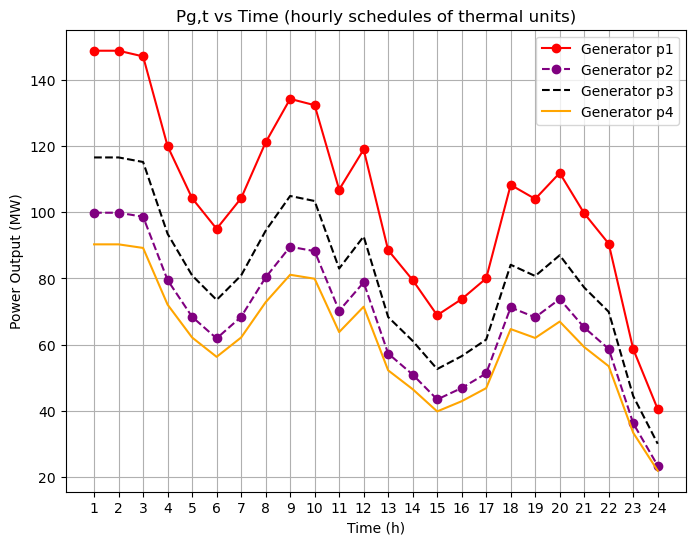

In [67]:
g1_values = [model.p['p1', t].value for t in model.t_hours]
g2_values = [model.p['p2', t].value for t in model.t_hours]
g3_values = [model.p['p3', t].value for t in model.t_hours]
g4_values = [model.p['p4', t].value for t in model.t_hours]


# g1_values = func_max(g1_values,200)
# g2_values = func_max(g2_values,177)
# g3_values = func_max(g3_values,190)
# g4_values = func_max(g4_values,160)

plt.figure(figsize=(8, 6))
plt.plot(t_hours, g1_values, 'o-', label='Generator p1',color='red')
plt.plot(t_hours, g2_values, 'o-',linestyle='dashed', color='purple',label='Generator p2')
plt.plot(t_hours, g3_values, '-', linestyle='dashed', color='black',label='Generator p3')
plt.plot(t_hours, g4_values, '-', color='orange',label='Generator p4')
plt.xlabel('Time (h)')
plt.ylabel('Power Output (MW)')
plt.title('Pg,t vs Time (hourly schedules of thermal units)')
plt.xticks(t_hours, xticks)
plt.legend()
plt.grid()
plt.show()

In [68]:
g1_values

[148.88356029324214,
 148.88356029350206,
 147.16242352228588,
 120.0067100849117,
 104.27165315034901,
 95.01835405528904,
 104.27165314574917,
 121.15413459629333,
 134.31764357728022,
 132.41323954578695,
 106.87507400842512,
 119.01865008837967,
 88.5481547269621,
 79.52812314512191,
 68.88257351452506,
 73.75912768844823,
 80.02449642214654,
 108.30935464829568,
 104.05399191616578,
 111.91099269816146,
 99.70367081027541,
 90.52427471848978,
 58.65137162020032,
 40.48052977889843]